In [1]:
import pandas as pd
import numpy as np
from dataprep.eda import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)


from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from scipy.stats import probplot
import scipy.stats as stats
from scipy.stats import boxcox

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\holoviews\plotting\util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


In [ ]:
hts = pd.DataFrame()
folder = os.getcwd() + '\\01_제공데이터\\'

for df in os.listdir('./01_제공데이터/') :
    if 'HTS' in df :
        hts = pd.concat([hts,pd.read_csv(folder + df,encoding = 'cp949')],axis = 0 ,ignore_index=True)
        
hts.to_csv('hts.csv',index = False)

In [2]:
hts = pd.read_csv('hts.csv')

target_player = [76232,68050,75847,67341,79192,78224,78513,76290,79215,67872]

hts.columns = [col.lower() for col in hts.columns]

hts.insert(1,'날짜',pd.to_datetime(hts['g_id'].apply(lambda x : x[:8])))

In [3]:
plot(hts.loc[hts['hit_result']=='1루타'],'pit_vel','hit_ang_ver')

- 안타의 평균 발사각도는 10도 내외이고 투수들의 구속이 올라가면 이상치도 많아지고 발사각도도 조금씩 줄어든다.

In [4]:
plot(hts.loc[hts['hit_result']=='1루타'],'pit_vel','hit_vel')

- 구속이 높을수록 타구속도도 빨라지는것이 보인다

In [5]:
hits = ['1루타','2루타','3루타','홈런']

<Figure size 864x720 with 0 Axes>

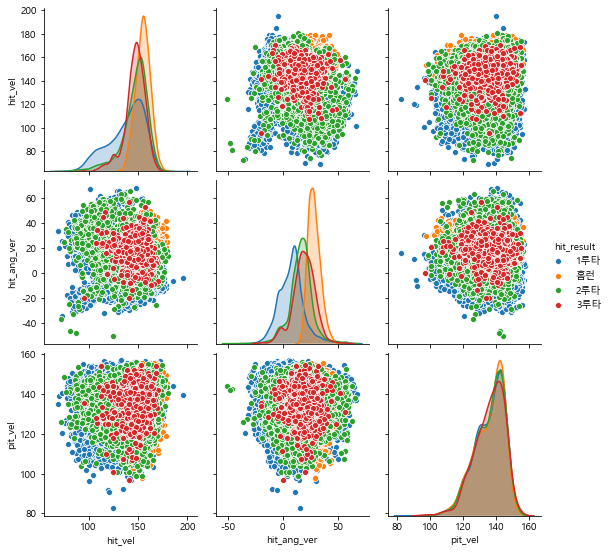

In [6]:
plt.figure(figsize = (12,10))
sns.pairplot(hts.query('hit_result in @hits')[['hit_vel','hit_ang_ver','pit_vel','hit_result']],hue = 'hit_result')
plt.show()

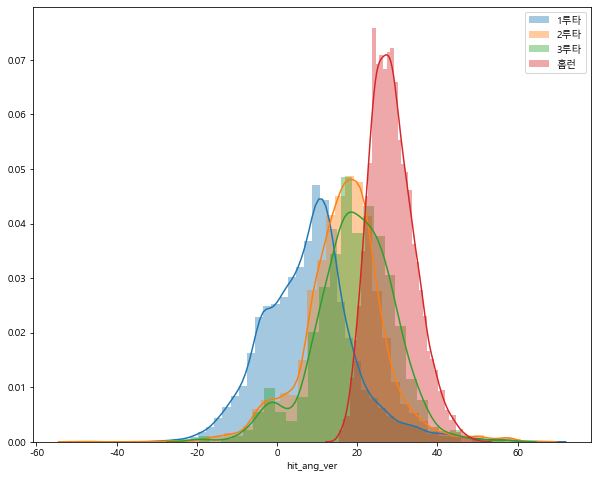

In [22]:
plt.figure(figsize = (10,8))
for i,hit in enumerate(sorted(hits)) :
    sns.distplot(hts.query('hit_result in @hits').loc[hts['hit_result']==hit]['hit_ang_ver'],label=hit)
    
plt.legend()
plt.show()

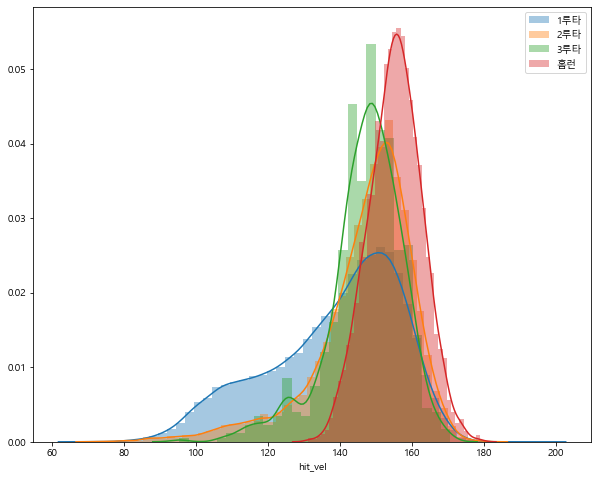

In [24]:
plt.figure(figsize = (10,8))
for i,hit in enumerate(sorted(hits)) :
    sns.distplot(hts.query('hit_result in @hits').loc[hts['hit_result']==hit]['hit_vel'],label=hit)
    
plt.legend()
plt.show()

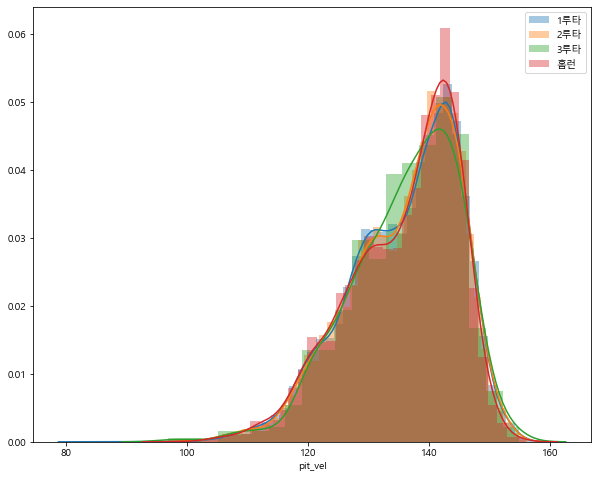

In [25]:
plt.figure(figsize = (10,8))
for i,hit in enumerate(sorted(hits)) :
    sns.distplot(hts.query('hit_result in @hits').loc[hts['hit_result']==hit]['pit_vel'],label=hit)
    
plt.legend()
plt.show()

- 안타에서 투수 구속과는 별 관계 없는듯 보인다.

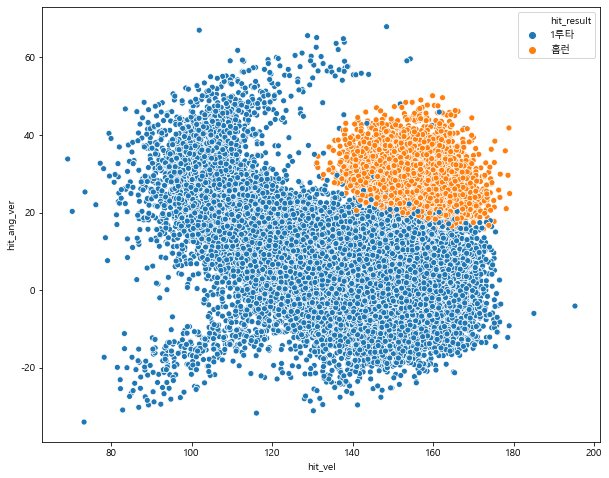

In [41]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = 'hit_vel',y ='hit_ang_ver',data = hts.query('hit_result in @hits').loc[(hts['hit_result']=='1루타')|(hts['hit_result']=='홈런')],hue = 'hit_result')
plt.show()

In [34]:
hts['hit_result'].unique()

array(['플라이', '1루타', '번트안타', '땅볼아웃', '홈런', '2루타', '파울플라이', '3루타', '직선타',
       '희생번트', '내야안타(1루타)', '희생플라이', '병살타', '인필드플라이', '번트아웃', '야수선택',
       '삼중살타'], dtype=object)

- 번트안타, 번트아웃, 희생번트는 제외

In [7]:
bunt = ['번트안타','번트아웃','희생번트']

In [8]:
new_hts = hts.query('hit_result not in @bunt').reset_index(drop = True)

In [9]:
new_hts['hit_result'].unique()

array(['플라이', '1루타', '땅볼아웃', '홈런', '2루타', '파울플라이', '3루타', '직선타',
       '내야안타(1루타)', '희생플라이', '병살타', '인필드플라이', '야수선택', '삼중살타'],
      dtype=object)

In [11]:
flys = ['플라이','파울플라이','희생플라이']
grounds = ['땅볼아웃','병살타','야수선택','삼중살타','내야안타(1루타)']
short= ['1루타']
long = ['2루타','3루타']
hr = ['홈런']

hit_list = [flys,grounds,short,long,hr]

In [12]:
result = []

for value in new_hts['hit_result'] :
    if value in flys :
        result.append('플라이타구')
    elif value in grounds :
        result.append('땅볼타구')
    elif value in short :
        result.append('안타')
    elif value in long:
        result.append('23루타')
    elif value in hr :
        result.append('홈런')
    else :
        result.append('무소속')

In [14]:
new_hts['hit_newresult'] = result

In [17]:
eda_df = new_hts.loc[new_hts['hit_newresult']!='무소속']

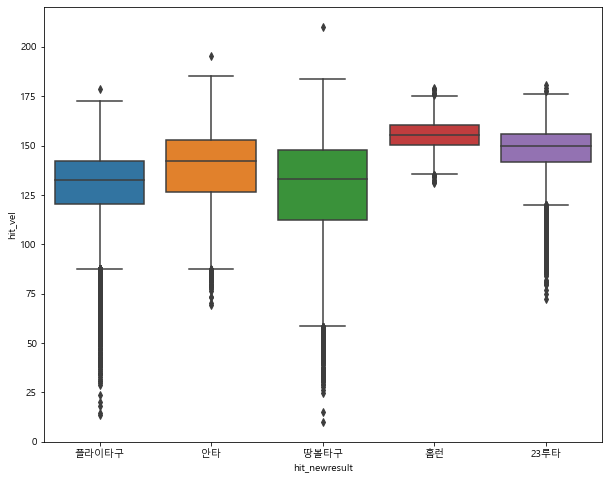

In [19]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'hit_newresult',y = 'hit_vel',data = eda_df)
plt.show()

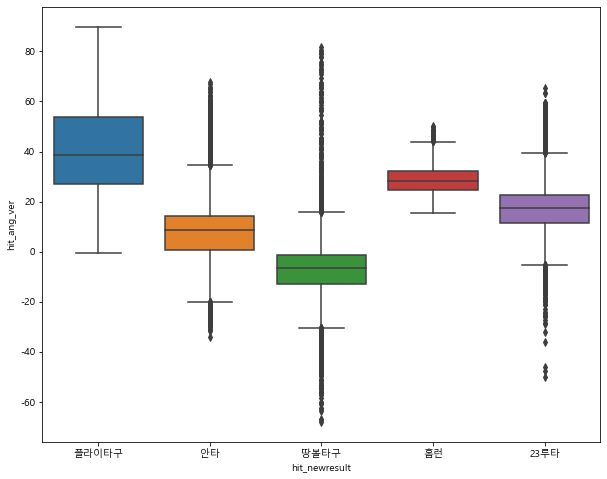

In [22]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'hit_newresult',y = 'hit_ang_ver',data = eda_df)
plt.show()

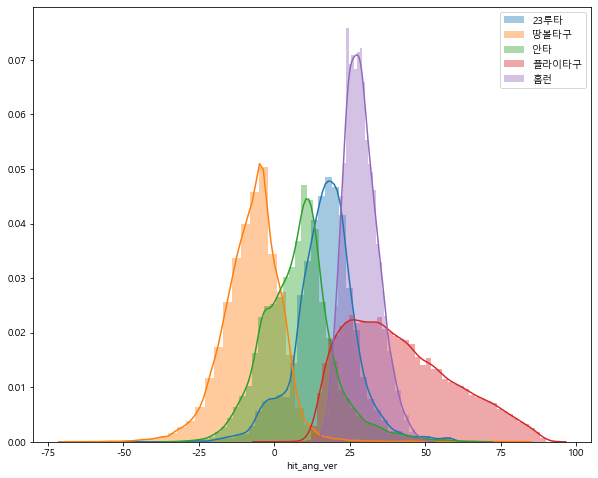

In [29]:
hit_col = sorted(eda_df['hit_newresult'].unique())

plt.figure(figsize = (10,8))
for i,hit in enumerate(hit_col) :
    df = eda_df.query('hit_newresult in @hit')
    sns.distplot(df['hit_ang_ver'],label = hit_col[i])

plt.legend()
plt.show()

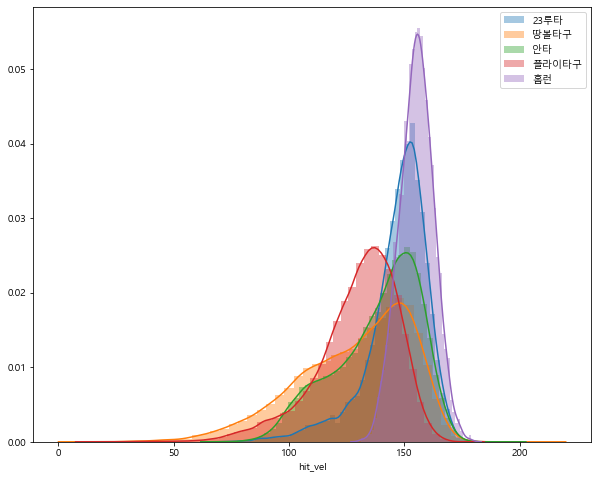

In [31]:
plt.figure(figsize = (10,8))
for i,hit in enumerate(hit_col) :
    df = eda_df.query('hit_newresult in @hit')
    sns.distplot(df['hit_vel'],label = hit_col[i])

plt.legend()
plt.show()

In [32]:
cluster_df = new_hts[['hit_vel','hit_ang_ver','hit_result']]

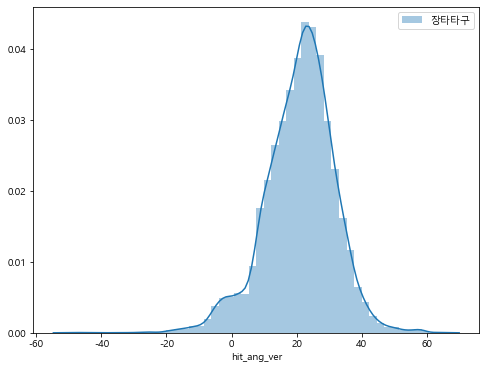

In [38]:
long_hits = ['23루타','홈런']
plt.figure(figsize = (8,6))
sns.distplot(eda_df.query('hit_newresult in @long_hits')['hit_ang_ver'],label = ['장타타구'])
plt.legend()
plt.show()

- 각도는 크다고 좋은 것이 아님
- 20 ~ 30도가 가장 이상적인 타구이기에 스케일링 시 유의해야한다.


- 대부분 스케일링의 경우 값이 높을수록 스케일링 후에도 값이 크기 때문에 새로 정의를 할 필요가 있다.
    - 그래서 홈런과 2,3루타의 타구각도의 중위값을 기준으로 계산
    
   
- 속도의 경우 빠를수록 좋기 때문에 속도의 경우 스케일링이 상관없지만, robustscale을 할 경우 이상치도 잡아주는 효과도 있기에 robustscale을 사용한다.

In [9]:
def median_scaler(data,target,median) :
    
    scale_list = []
    for value in data[target] :
        scale_list.append(1-np.abs((median - value) / median))
    
    return scale_list

In [10]:
long_hits = ['2루타','3루타','홈런']

new_hts.query('hit_result in @long_hits')['hit_ang_ver'].describe()

count    13550.000000
mean        21.017424
std         10.687654
min        -50.200000
25%         14.800000
50%         21.900000
75%         27.800000
max         65.400000
Name: hit_ang_ver, dtype: float64

- 21.9도를 기준으로 scale을 만들 것이다.

In [11]:
cluster_df['scale_angle'] = median_scaler(cluster_df,'hit_ang_ver',21.9)

robust = RobustScaler()
cluster_df['scale_vel'] = robust.fit_transform(cluster_df['hit_vel'].values.reshape(-1,1)).reshape(1,-1)[0]

In [12]:
def cluster_decision(scale_df):
    sum_of_squared_distances = []
    k = range(1,10)
    for i in k :
        km = KMeans(n_clusters=i)
        km = km.fit(scale_df)
        sum_of_squared_distances.append(km.inertia_)
    plt.plot(k,sum_of_squared_distances,'bx-')
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Distances')
    plt.title("Elbow Method For Optimal K")
    plt.show()

    
def cluster_scatterplot(df,vel,ang,hue) :
    plt.figure(figsize = (10,8))
    sns.scatterplot(x = ang,y =vel,data = df,hue=hue)
    plt.legend()
    plt.show()

In [14]:
def outlier_idx(df) :
    
    outlier_list = []    
    q25 = np.percentile(df['hit_vel'].values,25)
    q75 = np.percentile(df['hit_vel'].values,75)

    q_25 = np.percentile(df['hit_ang_ver'].values,25)
    q_75 = np.percentile(df['hit_ang_ver'].values,75)

    iqr = q75 - q25
    iqr2 = q_75 - q_25

    iqr_weight = iqr *1.5
    iqr_weight2 = iqr2 * 1.5

    lowest = q25 - iqr_weight
    highest = q75 + iqr_weight

    lowest2 = q_25 - iqr_weight2
    highest2 = q_75 + iqr_weight2

    vel_list = df.loc[(df['hit_vel']<lowest) | (df['hit_vel']>highest)].index.tolist()
    ang_list = df.loc[(df['hit_ang_ver']<lowest2) | (df['hit_ang_ver']>highest2)].index.tolist()

    vel_list.extend(ang_list)

    vel_list = list(set(vel_list))

    outlier_list.extend(vel_list)
        
    return outlier_list


def outlier_idx2(data,target) :
    
    outlier_idx = []
    for value in data[target].unique():
        
        df = data.loc[data[target]==value]
        
        q25 = np.percentile(df['hit_vel'].values,25)
        q75 = np.percentile(df['hit_vel'].values,75)

        q_25 = np.percentile(df['hit_ang_ver'].values,25)
        q_75 = np.percentile(df['hit_ang_ver'].values,75)

        iqr = q75 - q25
        iqr2 = q_75 - q_25

        iqr_weight = iqr *1.5
        iqr_weight2 = iqr2 * 1.5

        lowest = q25 - iqr_weight
        highest = q75 + iqr_weight

        lowest2 = q_25 - iqr_weight2
        highest2 = q_75 + iqr_weight2

        vel_list = df.loc[(df['hit_vel']<lowest) | (df['hit_vel']>highest)].index.tolist()
        ang_list = df.loc[(df['hit_ang_ver']<lowest2) | (df['hit_ang_ver']>highest2)].index.tolist()

        vel_list.extend(ang_list)

        vel_list = list(set(vel_list))
        
        outlier_idx.extend(vel_list)
        
    return outlier_idx2

In [15]:
outlier_list = outlier_idx(cluster_df)

outlier_df = cluster_df.drop(index = outlier_list).reset_index(drop = True)

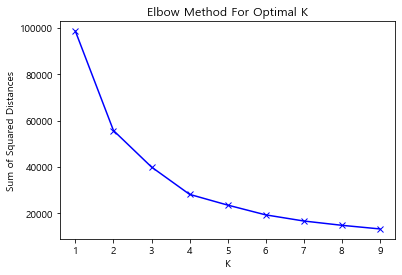

In [16]:
cluster_decision(outlier_df[['scale_vel','scale_angle']])

In [17]:
for i in range(2,6) :
    kmeans = KMeans(n_clusters=i,n_jobs=-1)
    km = kmeans.fit(outlier_df[['scale_vel','scale_angle']])
    
    print(f'군집{i}개',davies_bouldin_score(outlier_df[['scale_vel','scale_angle']],km.labels_))

군집2개 1.0224493149910419
군집3개 0.9236674495679589
군집4개 0.8661049340868426
군집5개 0.8765962820183553


- 군집이 4개일때 값이 제일 낮다.

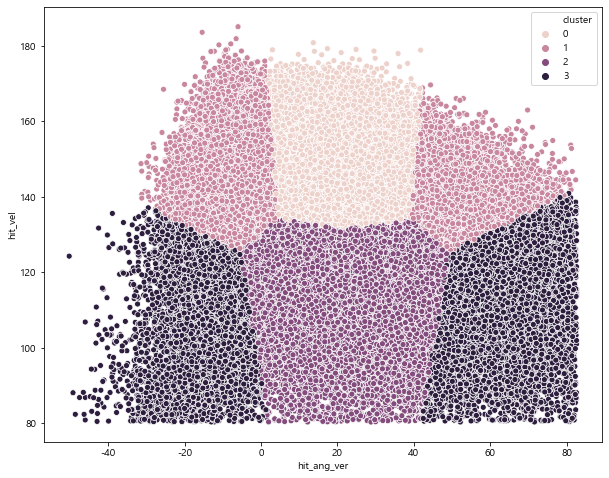

In [20]:
kmeans = KMeans(n_clusters=4,random_state=123)
km = kmeans.fit(outlier_df[['scale_vel','scale_angle']])
outlier_df['cluster'] = km.labels_

cluster_scatterplot(outlier_df,'hit_vel','hit_ang_ver','cluster')

In [21]:
outlier_df

,hit_vel,hit_ang_ver,hit_result,scale_angle,scale_vel,cluster
0,131.50,42.7,플라이,0.050228,-0.226599,1
1,135.18,9.9,1루타,0.452055,-0.093603,0
2,152.41,2.1,1루타,0.095890,0.529093,1
3,113.72,13.5,1루타,0.616438,-0.869172,2
4,161.90,3.5,1루타,0.159817,0.872064,0
...,...,...,...,...,...,...
117682,141.23,-4.9,땅볼아웃,-0.223744,0.125045,1
117683,101.09,31.8,1루타,0.547945,-1.325623,2
117684,146.84,33.4,홈런,0.474886,0.327792,0
117685,146.12,23.9,홈런,0.908676,0.301771,0


<Figure size 432x288 with 0 Axes>

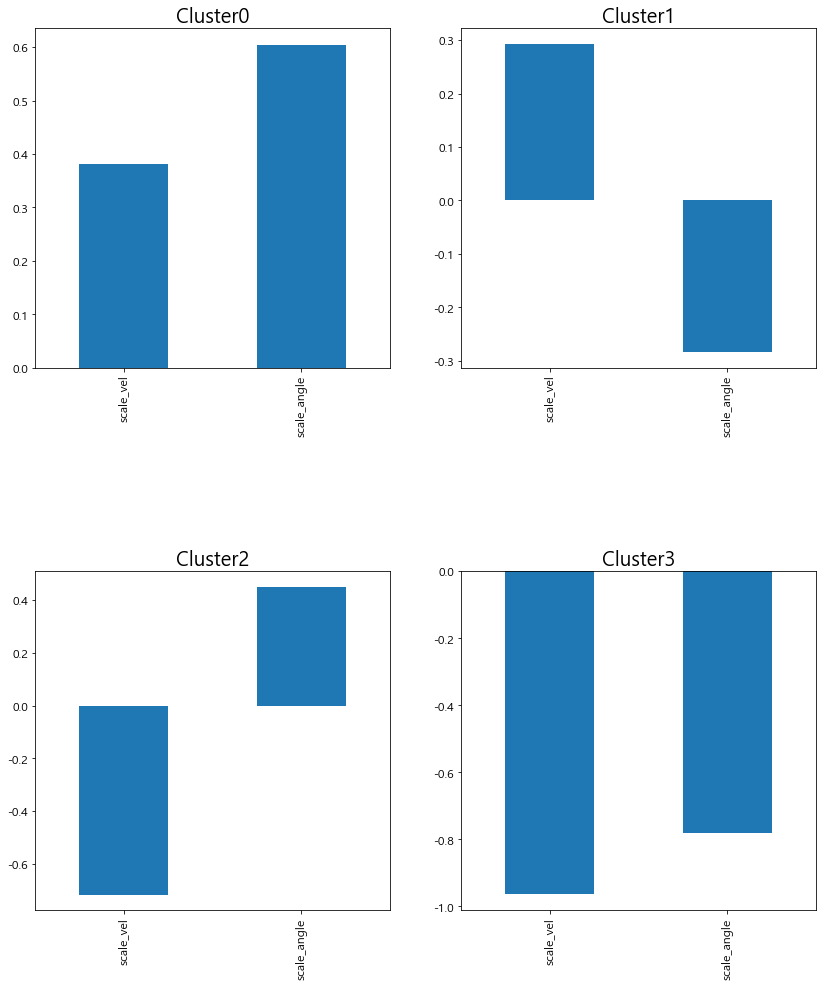

In [22]:
i = 0
plt.figure()
fig,ax = plt.subplots(2,2,figsize = (14,14))
for num in sorted(outlier_df['cluster'].unique()) :   
    i+=1
    plt.subplot(2,2,i)
    plt.title("Cluster{}".format(num),fontsize = 20)
    outlier_df.loc[outlier_df['cluster'] == num][['scale_vel','scale_angle']].mean().plot.bar()
    locs,labels = plt.xticks()
    plt.subplots_adjust(hspace =.6, top = 1)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.show()

#### Clsuter0번이 제일 이상적으로 보인다

- 타구속도도 제일 빠르고, 타구각도도 23루타,홈런의 타구각도 중위값 근처에 머물고 있기 때문

<Figure size 432x288 with 0 Axes>

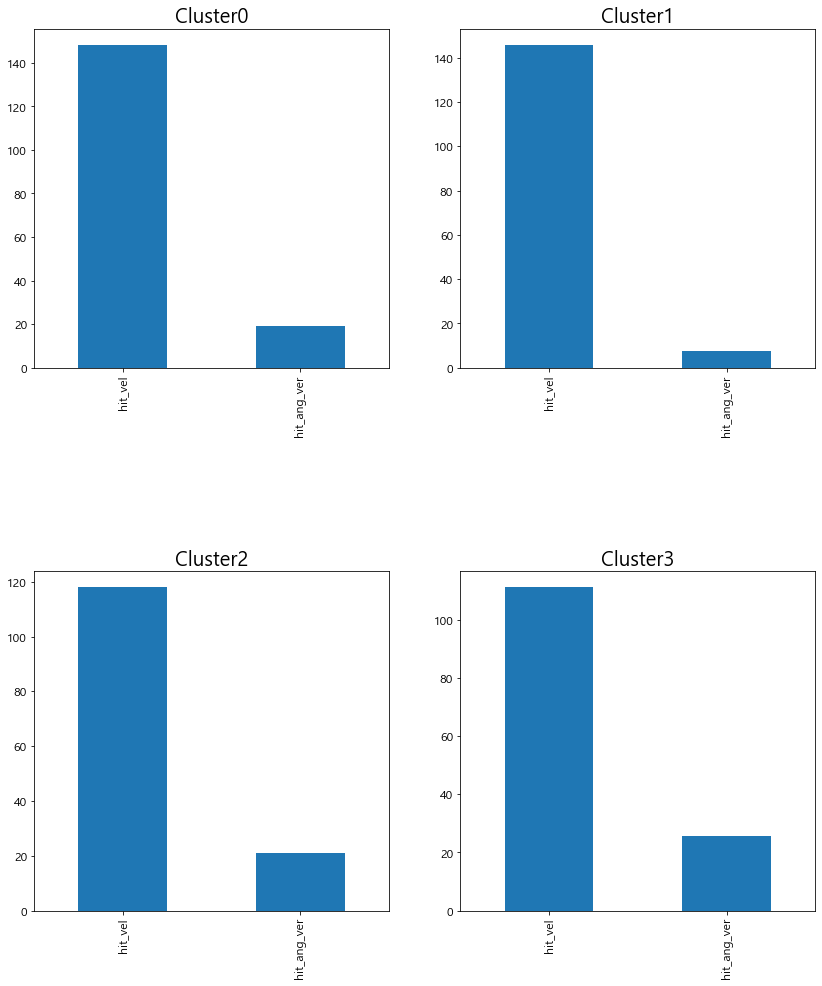

In [23]:
i = 0
plt.figure()
fig,ax = plt.subplots(2,2,figsize = (14,14))
for num in sorted(outlier_df['cluster'].unique()) :   
    i+=1
    plt.subplot(2,2,i)
    plt.title("Cluster{}".format(num),fontsize = 20)
    outlier_df.loc[outlier_df['cluster'] == num][['hit_vel','hit_ang_ver']].mean().plot.bar()
    locs,labels = plt.xticks()
    plt.subplots_adjust(hspace =.6, top = 1)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.show()

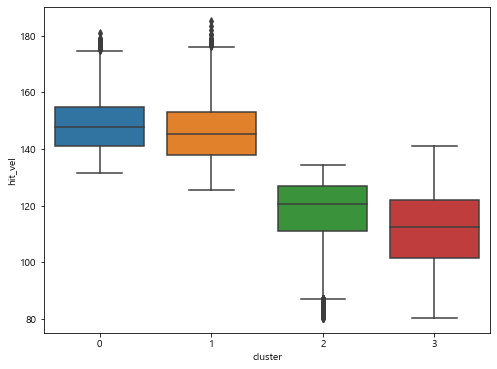

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster',y='hit_vel',data = outlier_df)
plt.show()

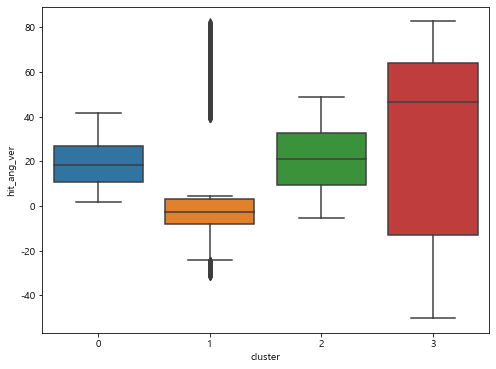

In [26]:
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster',y='hit_ang_ver',data = outlier_df)
plt.show()

- boxplot을 통해 확실히 알 수 있었다.
- 타구속도의 경우 cluster0과 cluster1이 차이가 별로 없지만, 타구 각도의 경우는 0번이 평균이 대략 20도를 기준으로 boxplot이 형성되었기에 좋은 타구라고 할 수 있다.

In [165]:
outlier_df['target'] = outlier_df['cluster'].apply(lambda x : 1 if x==0 else 0)

In [167]:
outlier_df

,hit_vel,hit_ang_ver,hit_result,scale_angle,scale_vel,cluster,target
0,131.50,42.7,플라이,0.050228,-0.226599,1,0
1,135.18,9.9,1루타,0.452055,-0.093603,0,1
2,152.41,2.1,1루타,0.095890,0.529093,1,0
3,113.72,13.5,1루타,0.616438,-0.869172,2,0
4,161.90,3.5,1루타,0.159817,0.872064,0,1
...,...,...,...,...,...,...,...
117682,141.23,-4.9,땅볼아웃,-0.223744,0.125045,1,0
117683,101.09,31.8,1루타,0.547945,-1.325623,2,0
117684,146.84,33.4,홈런,0.474886,0.327792,0,1
117685,146.12,23.9,홈런,0.908676,0.301771,0,1


In [168]:
logistic = LogisticRegression(random_state=123,n_jobs=-1)

logistic.fit(outlier_df[['scale_vel','scale_angle']],outlier_df['target'])

LogisticRegression(n_jobs=-1, random_state=123)

In [184]:
logistic.coef_[0]

array([6.18468538, 8.81488356])

- 6.1847 * scale_vel + 8.8149 * scale_angle -> 배럴타구 수식

In [172]:
new_hts['barrel1'] = logistic.predict(cluster_df[['scale_vel','scale_angle']])

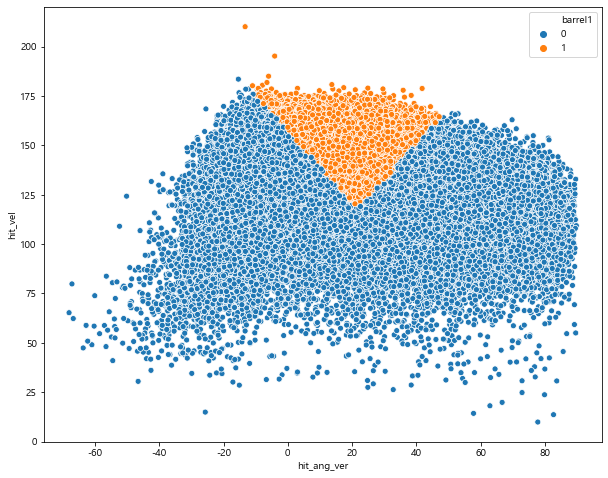

In [174]:
cluster_scatterplot(new_hts,'hit_vel','hit_ang_ver','barrel1')

- 20도를 기준으로 각이 커지거나 작아질수록 타구속도는 빨라져야 배럴이 됨을 알 수 있다.

In [175]:
new_hts['barrel1'].value_counts()

0    80287
1    40127
Name: barrel1, dtype: int64

In [180]:
new_hts.loc[new_hts['barrel1']==1][['hit_vel','hit_ang_ver']].describe()

,hit_vel,hit_ang_ver
count,40127.000000,40127.000000
mean,148.650259,18.530772
std,10.402776,9.528670
min,118.360000,-13.300000
25%,141.595000,11.600000
50%,149.260000,18.700000
75%,156.110000,25.400000
max,210.130000,47.100000


In [186]:
new_hts.to_csv('barrel.csv',index = False)